<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/APRENDIZAJE_NO_SUPERVISADO/blob/main/Semana_6%20CON%20TAREA%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tema 3 — Aprendizaje no supervisado


# 3.1. Definición y principios básicos

## ¿Qué es el aprendizaje no supervisado?
- Rama del **Machine Learning** que trabaja con **datos sin etiquetas**.
- El objetivo principal no es predecir una salida conocida, sino **descubrir patrones ocultos**, estructuras o relaciones en los datos.
- Se usa principalmente en **exploración, segmentación y reducción de dimensionalidad**.

---

## Diferencias con el aprendizaje supervisado
- **Supervisado:** requiere etiquetas (ej. diagnosticar enfermedad: sano/enfermo).
- **No supervisado:** no tiene etiquetas, el algoritmo organiza o resume los datos.
- En supervisado se mide la calidad con métricas claras (accuracy, F1, ROC–AUC).
- En no supervisado la evaluación es **interna** (cohesión/separación) o **comparativa** (cuando existe un “ground truth”).

---

## Principios fundamentales
- **Similitud y distancia**:
  - Euclídea, Manhattan, Coseno, según el tipo de datos.
- **Escalado de variables**:
  - Imprescindible porque los algoritmos de clustering dependen de magnitudes.
  - Ejemplo: “altura en cm” y “peso en kg” deben compararse en escalas similares.
- **Densidad y forma de los clusters**:
  - No siempre son esféricos o de igual tamaño (limitación de algunos métodos).
- **Sensibilidad al ruido/outliers**:
  - Valores extremos pueden alterar centroides o generar clusters falsos.

---

## Limitaciones y consideraciones éticas
- **Reificación de clusters**: peligro de asumir que los grupos encontrados son “reales” o “naturales”.
- **Sesgos por variables dominantes**: una variable mal preprocesada puede imponer la estructura.
- **Interpretación responsable**:
  - Comunicar claramente los supuestos.
  - No usar clusters para etiquetar personas sin un marco ético (ej. segmentación sensible en salud o educación).

---

📌 **Mensaje clave**:  
El aprendizaje no supervisado **no garantiza una única “verdad” en los datos**, sino diferentes maneras útiles de organizarlos. La interpretación depende del contexto, las variables usadas y las decisiones tomadas en el preprocesamiento.


# 3.2. Tipos de problemas comunes

El aprendizaje no supervisado se aplica en diferentes contextos. Los problemas más comunes son:

---

## 1. Clustering (Agrupamiento)
- **Objetivo:** dividir los datos en grupos (clusters) de elementos similares entre sí.
- **Ejemplos de uso:**
  - Segmentación de clientes en marketing.
  - Agrupación de genes con comportamientos similares.
  - Detección de patrones en sensores o dispositivos IoT.
- **Algoritmos típicos:** K-means, agrupamiento jerárquico, DBSCAN, Gaussian Mixture Models (GMM).

---

## 2. Reducción de dimensionalidad
- **Objetivo:** representar los datos en menos dimensiones sin perder demasiada información.
- **Beneficios:**
  - Facilita la **visualización** (ej. pasar de 50 variables a 2D o 3D).
  - Reduce el ruido y la redundancia.
  - Mejora la eficiencia en algoritmos posteriores.
- **Métodos comunes:**
  - **PCA (Análisis de Componentes Principales)**.
  - **t-SNE** (para visualización en 2D/3D).
  - **UMAP** (estructuras no lineales, útil en grandes volúmenes de datos).

---

## 3. Detección de anomalías
- **Objetivo:** identificar observaciones que no encajan en el comportamiento general.
- **Ejemplos:**
  - Transacciones fraudulentas en sistemas bancarios.
  - Fallos en sensores de maquinaria industrial.
  - Errores o valores atípicos en registros médicos.
- **Enfoques habituales:**
  - Basados en distancia (ej. vecinos lejanos).
  - Basados en densidad (ej. DBSCAN, Isolation Forest).
  - Basados en reconstrucción (ej. autoencoders).

---

## 4. Otros usos
- **Recomendadores:** organizar usuarios o productos por similitud.
- **Compresión de datos:** reducir volumen manteniendo estructura esencial.
- **Preprocesamiento:** servir de paso previo para modelos supervisados.

---

📌 **Mensaje clave**:  
Los problemas de aprendizaje no supervisado **no buscan predecir etiquetas**, sino **descubrir estructura**. Los resultados dependen del método elegido, las variables disponibles y el preprocesamiento aplicado.


In [7]:
# ============================================
# 0) Setup básico
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
plt.rcParams["figure.figsize"] = (7, 5)


## 3.2.1. EDA mínimo para clustering (Dataset: Iris)

Antes de aplicar algoritmos de aprendizaje no supervisado es necesario realizar un **EDA (Exploratory Data Analysis) mínimo**, incluso cuando no tenemos etiquetas.  
El objetivo es **entender las variables, escalas y posibles outliers**, ya que los métodos de clustering son sensibles a estos factores.

---

### 1. Conocer la estructura de los datos
- Revisar número de filas y columnas (`shape`).
- Tipos de variables (`info()`).
- Estadísticas básicas (`describe()`).

👉 Esto permite identificar si las variables están en **diferentes escalas** (cm, kg, etc.).

---

### 2. Distribuciones por variable
- Histogramas o **boxplots** para revisar rangos y dispersión.
- Permiten detectar variables con escalas muy diferentes o valores atípicos.

👉 Ejemplo: en Iris, `sepal length` y `petal length` pueden tener rangos distintos.




In [8]:
# ============================================
# 1) Carga de datos (Iris) y preparación
# ============================================
iris = load_iris(as_frame=True)
X = iris.data.copy()          # Solo features (no usamos etiquetas para no supervisado)
feature_names = X.columns.tolist()

print("Shape:", X.shape)
display(X.head())

# Estadísticas básicas
display(X.describe())


Shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


---

### 3. Correlaciones
- Matriz de correlación para revisar redundancias.
- Si dos variables están muy correlacionadas, un método de reducción de dimensionalidad como **PCA** puede ser útil.

---

### 4. Escalado de datos
- Es **fundamental** porque muchos algoritmos (K-means, DBSCAN) se basan en distancias.
- Opciones comunes:
  - **StandardScaler**: transforma media = 0 y desviación estándar = 1.
  - **MinMaxScaler**: lleva los valores a un rango [0,1].
  - **RobustScaler**: útil cuando hay outliers.

---

### 5. Visualización preliminar con PCA
- Usar **PCA 2D o 3D** para observar si hay cierta estructura de grupos en los datos.
- Recordar que:
  - No habrá separación perfecta.
  - La visualización es solo un **apoyo exploratorio**.

---

📌 **Mensaje clave**:  
El EDA en aprendizaje no supervisado **no busca relaciones con etiquetas**, sino garantizar que los datos están listos para aplicar clustering. Un buen preprocesamiento (escalado, reducción de dimensionalidad) es la base para obtener clusters significativos.

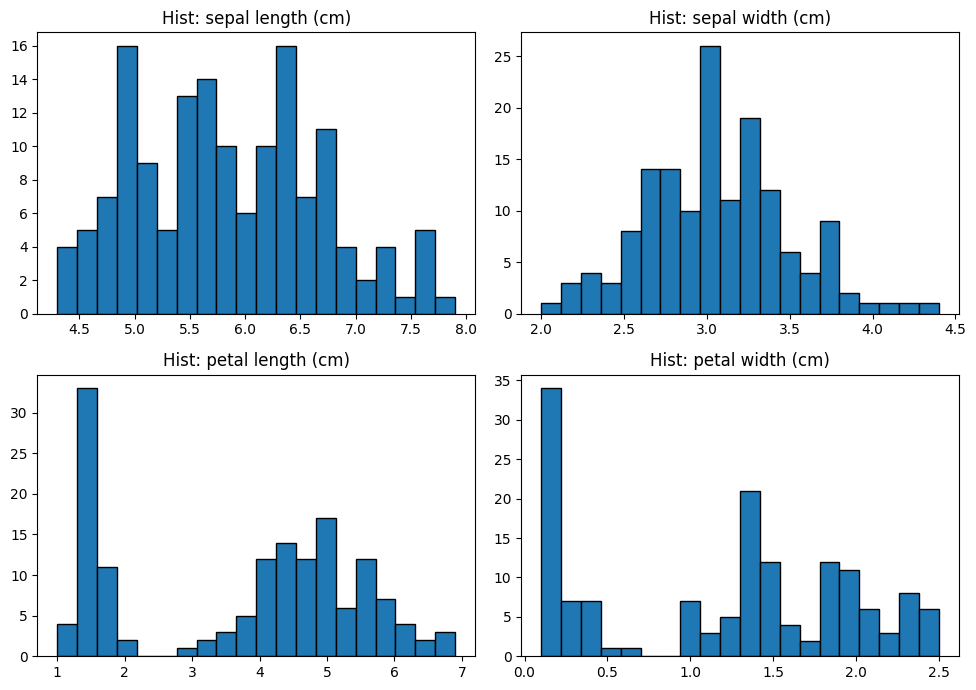

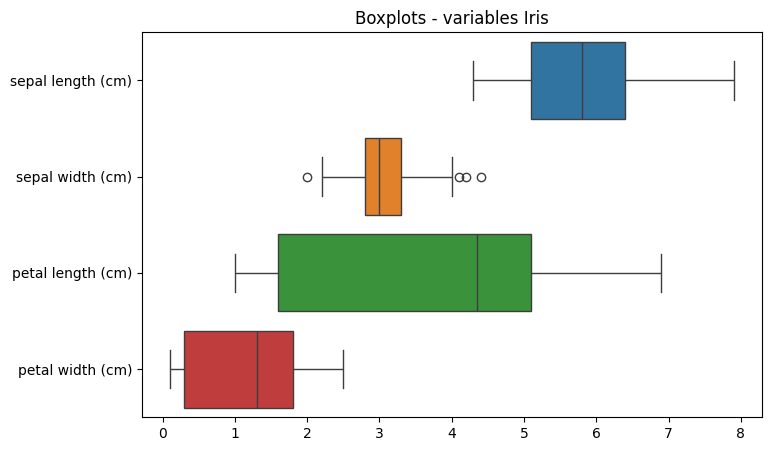

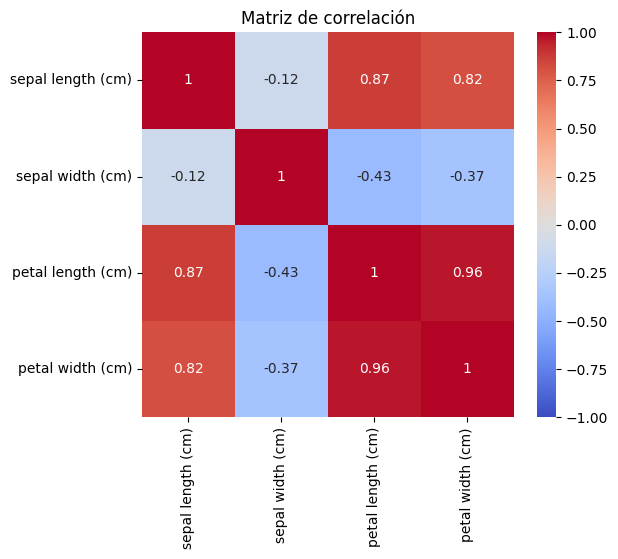

In [9]:
# ============================================
# 2) EDA mínimo (distribuciones, boxplots, correlaciones)
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(10,7))
axes = axes.ravel()
for i, col in enumerate(feature_names):
    axes[i].hist(X[col], bins=20, edgecolor="k")
    axes[i].set_title(f"Hist: {col}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(8,5))
sns.boxplot(data=X, orient="h")
plt.title("Boxplots - variables Iris")
plt.show()

# Correlación
plt.figure(figsize=(6,5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación")
plt.show()


Varianza explicada PCA2: [0.73  0.229]
Varianza explicada PCA3: [0.73  0.229 0.037]


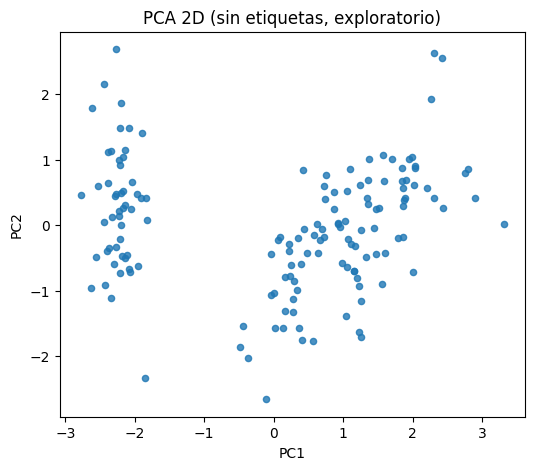

In [10]:
# ============================================
# 3) Escalado + PCA preliminar (visual exploratoria)
# ============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)

print("Varianza explicada PCA2:", pca2.explained_variance_ratio_.round(3))
print("Varianza explicada PCA3:", pca3.explained_variance_ratio_.round(3))

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=20, alpha=0.8)
plt.title("PCA 2D (sin etiquetas, exploratorio)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()



## ¿Cómo elegir el número de clusters (k)?

### 1. Método del Codo (*Elbow Method*)
- Se grafica la **inercia (SSE)** en función de k.
- Al aumentar k, la inercia siempre disminuye (más centroides = mejor ajuste).
- El punto donde la mejora deja de ser significativa (forma de “codo”) sugiere el k adecuado.

### 2. Silhouette Score
- Mide la calidad de la separación entre clusters:
  - Valores cercanos a **1**: puntos bien asignados.
  - Valores cercanos a **0**: puntos en el borde entre dos clusters.
  - Valores negativos: puntos mal asignados.
- Permite comparar diferentes valores de k y elegir el que maximiza la métrica.

---

📌 **Mensaje clave:**  
- **K-means es rápido y escalable**, pero requiere un criterio externo para definir `k`.  
- La combinación de **Elbow + Silhouette** ofrece una manera práctica y visual de decidir cuántos clusters usar.

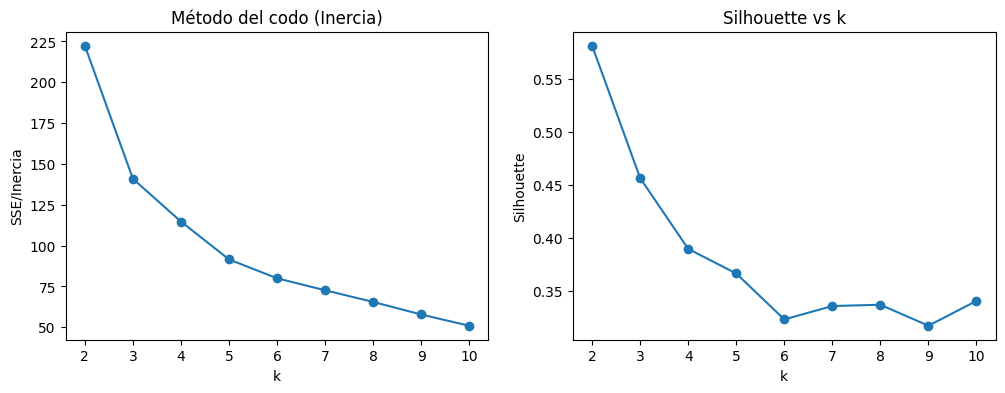

✔ k óptimo por silhouette: 2 | silhouette=0.582


In [11]:
# ============================================
# 4) Selección de k para K-means (Elbow + Silhouette)
# ============================================
inertias = []
sil_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ks, inertias, marker="o")
ax[0].set_title("Método del codo (Inercia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("SSE/Inercia")

ax[1].plot(ks, sil_scores, marker="o")
ax[1].set_title("Silhouette vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.show()

k_opt = ks[int(np.argmax(sil_scores))]
print(f"✔ k óptimo por silhouette: {k_opt} | silhouette={max(sil_scores):.3f}")


# K-means: Funcionamiento y selección del número de clusters

## ¿Cómo funciona K-means?
1. **Inicialización:** se eligen aleatoriamente `k` centroides (mejorado con *k-means++* para mayor estabilidad).
2. **Asignación:** cada punto se asigna al centroide más cercano (según distancia euclídea, aunque se pueden usar otras).
3. **Actualización:** se recalculan los centroides como la media de los puntos asignados.
4. **Iteración:** se repite el proceso hasta que los centroides dejan de cambiar significativamente o se alcanza un máximo de iteraciones.

---

## Función objetivo de K-means

El algoritmo busca **minimizar la suma de distancias cuadradas dentro de cada cluster**:

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Donde:

- $k$ = número de clusters.  
- $C_i$ = conjunto de puntos asignados al cluster $i$.  
- $\mu_i$ = centroide del cluster $i$.  
- $\|x - \mu_i\|^2$ = distancia euclídea al cuadrado entre el punto $x$ y su centroide.  

👉 Intuitivamente: cada cluster intenta ser lo más **compacto** posible alrededor de su centro.



---

## Limitaciones de K-means
- Requiere **especificar k** de antemano.
- Supone clusters aproximadamente **esféricos** y de tamaño similar.
- Sensible a **outliers** y a la **escala** de los datos.
- Todos los puntos se asignan forzosamente a un cluster (no maneja ruido explícito).

---




In [12]:
from IPython.display import Image
Image(filename="/content/K-means_convergence.gif")

FileNotFoundError: [Errno 2] No such file or directory: '/content/K-means_convergence.gif'

In [ ]:
k_fixed = 2  # <— prueba con 3 (o el que quieras)

kmeans = KMeans(n_clusters=k_fixed, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km) #Mide qué tan similar es un punto a su propio cluster (cohesión) comparado con otros clusters
ch_km  = calinski_harabasz_score(X_scaled, labels_km)#Es la razón entre la dispersión entre clusters y la dispersión dentro de los clusters.
db_km  = davies_bouldin_score(X_scaled, labels_km)
print(f"[K-means k={k_fixed}] silhouette={sil_km:.3f} | CH={ch_km:.1f} | DB={db_km:.3f}")

# ---- Proyección de los centroides a PCA 2D ----
centers_scaled = kmeans.cluster_centers_
centers_pca = pca2.transform(centers_scaled)  # proyectamos centroides al espacio PCA 2D

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_km, cmap="tab10", s=25, alpha=0.7, label="Puntos")
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", marker="X", s=200, label="Centroides")
plt.title(f"K-means (PCA 2D) — k={k_fixed}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

# ---- Centroides en escala original ----
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=feature_names)
centers_df.index = [f"Cluster {i}" for i in range(k_fixed)]
print("Centroides (escala original):")
display(centers_df.round(2))

# ---- Perfilado de clusters ----
df_km = X.copy()
df_km["cluster_km"] = labels_km
profile_km = df_km.groupby("cluster_km").mean().round(2)


In [ ]:
# ============================================
# EXTRA: Visualización PCA con etiquetas reales
# ============================================

y_true = iris.target  # etiquetas reales (Setosa=0, Versicolor=1, Virginica=2)
target_names = iris.target_names

plt.figure(figsize=(6,5))
for i, target in enumerate(np.unique(y_true)):
    plt.scatter(
        X_pca2[y_true == target, 0],
        X_pca2[y_true == target, 1],
        label=target_names[i],
        s=25, alpha=0.8
    )

plt.title("PCA 2D con clases reales (Iris)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


# Agrupamiento jerárquico (Ward)

## ¿Cómo funciona?
El agrupamiento jerárquico construye una **estructura en forma de árbol** (dendrograma), donde:
1. **Cada punto comienza como su propio cluster**.
2. En cada paso, se **fusionan los dos clusters más similares** según un criterio de enlace (*linkage*).
3. El proceso continúa hasta que todos los puntos pertenecen a un único cluster.
4. A partir del dendrograma, se puede elegir un **nivel de corte** para definir el número final de clusters.

---

## Tipos de enlace (*linkage*)
- **Single linkage**: usa la menor distancia entre puntos de dos clusters. Tiende a formar “cadenas”.
- **Complete linkage**: usa la mayor distancia entre puntos de dos clusters. Forma grupos más compactos.
- **Average linkage**: usa la distancia promedio entre todos los pares de puntos de dos clusters.
- **Ward linkage (el que usamos aquí)**: busca minimizar la **varianza interna** al fusionar clusters.

---

## Función objetivo de Ward
Ward intenta minimizar el **incremento de la suma de cuadrados (SSE)** en cada fusión:

$$
\Delta(C_i, C_j) = \frac{|C_i| \cdot |C_j|}{|C_i| + |C_j|} \; \| \mu_i - \mu_j \|^2
$$

Donde:
- $C_i, C_j$ son los clusters que se consideran para fusionar.
- $|C_i|, |C_j|$ son los tamaños de los clusters.
- $\mu_i, \mu_j$ son los centroides de cada cluster.
- $\| \mu_i - \mu_j \|^2$ es la distancia euclídea al cuadrado entre centroides.

👉 Intuitivamente: Ward fusiona los clusters cuya unión provoca el **menor aumento en la varianza total**.

---

## Ventajas
- No requiere fijar `k` de entrada, se puede explorar con el dendrograma.
- Es explicativo y útil en exploración de datos pequeños o medianos.
- Permite visualizar relaciones jerárquicas entre clusters.

## Limitaciones
- Poco escalable a datasets muy grandes (costo $O(n^2)$).
- Sensible a la elección del *linkage*.
- Difícil de interpretar en alta dimensionalidad sin reducción previa.

---

📌 **Mensaje clave:**  
El método jerárquico (Ward) busca construir una **estructura en árbol** y encontrar clusters al **minimizar la varianza interna**. El dendrograma es una herramienta poderosa para decidir **cuántos clusters** usar y entender cómo se relacionan entre sí.


In [ ]:
# ============================================
# 6) Agrupamiento jerárquico: dendrograma + etiquetas
# ============================================
# Dendrograma (usamos linkage sobre datos escalados)
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=12, leaf_rotation=45., show_contracted=True)
plt.title("Dendrograma (agglomerative, ward) - truncado")
plt.xlabel("Grupos combinados"); plt.ylabel("Distancia")
plt.show()

# Cortar en n_clusters = k_opt para comparar con K-means
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, labels_agg)
ch_agg  = calinski_harabasz_score(X_scaled, labels_agg)
db_agg  = davies_bouldin_score(X_scaled, labels_agg)
print(f"[Jerárquico/Ward] silhouette={sil_agg:.3f} | Calinski-Harabasz={ch_agg:.1f} | Davies-Bouldin={db_agg:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_agg, cmap="tab10", s=25)
plt.title("Jerárquico (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

## ¿Cómo funciona DBSCAN?
DBSCAN identifica clusters como **regiones densas** de puntos separadas por regiones de baja densidad.  
Se basa en dos parámetros principales:

- **eps**: radio de vecindad (ε).  
- **min_samples**: número mínimo de puntos que deben estar dentro de `eps` para considerar que hay suficiente densidad.

---

## Conceptos clave
- **Core point (punto núcleo):** un punto con al menos `min_samples` vecinos dentro de su radio `eps`.
- **Border point (punto frontera):** un punto que no es núcleo, pero está dentro del radio de `eps` de un núcleo.
- **Noise point (ruido, etiquetado como -1):** un punto que no cumple ninguna de las condiciones anteriores.

---

## Definición formal
Un cluster en DBSCAN se forma al conectar puntos núcleo que están a una distancia menor o igual que `eps`.  

- **Densidad alcanzable:** un punto $q$ es alcanzable desde un núcleo $p$ si $q$ está dentro de `eps` de $p$ o de una cadena de puntos núcleo conectados.  
- **Densidad conectada:** dos puntos están conectados si existe un núcleo desde el cual ambos son alcanzables.

---

## Parámetros
- **eps (ε):** controla el tamaño del vecindario.  
  - Pequeño → muchos puntos quedan aislados como ruido.  
  - Grande → los clusters se fusionan.  
- **min_samples:** determina cuántos puntos hacen falta para que una región sea considerada densa.  
  - Valores típicos: entre 4 y 6.  
  - Aumentar `min_samples` exige más densidad para formar un cluster.

---

## Ventajas
- No requiere especificar el número de clusters.  
- Detecta clusters de **forma arbitraria** (no necesariamente esféricos).  
- Maneja bien **ruido y outliers**.

## Limitaciones
- Sensible a la elección de `eps` y `min_samples`.  
- En datos con **densidad variable**, puede fallar en separar clusters correctamente.  
- En alta dimensionalidad, las distancias se vuelven menos informativas (maldición de la dimensionalidad).

---

📌 **Mensaje clave:**  
DBSCAN busca clusters donde los puntos están **lo suficientemente juntos** según `eps` y `min_samples`.  
A diferencia de K-means, puede dejar puntos sin asignar (ruido), lo cual es una ventaja cuando existen valores atípicos.


In [ ]:
# ============================================
# 7) DBSCAN: versión simple para clase
# ============================================

# DBSCAN agrupa puntos densos y marca como ruido a los aislados.
# Necesita dos parámetros:
# - eps: radio de vecindad
# - min_samples: vecinos mínimos para formar un cluster

# --- PASO 1: Estimar un buen valor de eps ---
min_samples = 5  # valor típico recomendado

# Calculamos distancias al 5º vecino más cercano
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])  # Distancia al 5º vecino

# Graficamos la curva k-dist para estimar un buen eps
plt.plot(k_dist)
plt.title("Curva k-dist (min_samples = 5)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 5º vecino")
plt.grid(True)
plt.show()

# Elige visualmente un valor de corte (por ejemplo: 0.5)
eps = 0.5  # (puede ajustarse según la curva anterior)

# --- PASO 2: Aplicar DBSCAN ---
db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(X_scaled)

# --- PASO 3: Evaluar si hay clusters útiles ---
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"Clusters encontrados (sin contar ruido): {n_clusters}")

# --- PASO 4: Métrica silhouette (sin ruido) ---
mask = labels_db != -1
if n_clusters >= 2:
    sil = silhouette_score(X_scaled[mask], labels_db[mask])
    print(f"Silhouette (sin ruido): {sil:.3f}")
else:
    print("No hay suficientes clusters para calcular silhouette.")

# --- PASO 5: Visualización (PCA 2D) ---
plt.figure(figsize=(6, 5))
colors = [
    sns.color_palette("tab10")[l % 10] if l != -1 else (0.6, 0.6, 0.6)
    for l in labels_db
]
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=colors, s=25)
plt.title("DBSCAN (PCA 2D) - gris = ruido")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Gaussian Mixture Models (GMM)

## ¿Qué es un GMM?
Un **Gaussian Mixture Model** asume que los datos provienen de una combinación de varias **distribuciones normales (gaussianas)**.  
Cada cluster se modela como una **distribución gaussiana** con su propia media y covarianza.

---

## Funcionamiento
- **Supuesto:** los datos son generados por una mezcla de $k$ gaussianas.  
- Cada punto tiene una **probabilidad** de pertenecer a cada cluster, no solo una asignación dura como en K-means.
- Se usa el algoritmo **EM (Expectation-Maximization)**:
  1. **E-step (Expectation):** calcular la probabilidad de que cada punto pertenezca a cada gaussiana (responsabilidades).
  2. **M-step (Maximization):** actualizar medias, covarianzas y pesos de las gaussianas para maximizar la verosimilitud.
  3. Repetir hasta convergencia.

---

## Función objetivo
El GMM busca **maximizar la log-verosimilitud** de los datos bajo el modelo:

$$
\mathcal{L} = \sum_{n=1}^{N} \log \left( \sum_{i=1}^{k} \pi_i \, \mathcal{N}(x_n \mid \mu_i, \Sigma_i) \right)
$$

Donde:
- $N$ = número de muestras.  
- $k$ = número de gaussianas (clusters).  
- $\pi_i$ = peso de la gaussiana $i$ (con $\sum \pi_i = 1$).  
- $\mu_i, \Sigma_i$ = media y covarianza de la gaussiana $i$.  
- $\mathcal{N}(x \mid \mu, \Sigma)$ = densidad de la normal multivariada.  

---

## Ventajas
- Permite **clusters elípticos** (no solo esféricos como K-means).  
- Ofrece **probabilidades de pertenencia** en lugar de asignaciones rígidas.  
- Flexible al modelar datos complejos.

## Limitaciones
- Se debe elegir `k` (número de componentes).  
- Sensible a la inicialización (aunque usa K-means++ por defecto).  
- Puede ser costoso en alta dimensionalidad.  

---

📌 **Mensaje clave:**  
GMM es un método probabilístico que extiende K-means: en lugar de dividir los datos en regiones rígidas, modela clusters como gaussianas y asigna **probabilidades suaves** a cada punto.


In [ ]:
from sklearn.mixture import GaussianMixture

# ============================================
# 8) Gaussian Mixture Models (GMM) flexible (sin funciones)
# ============================================

resultados = []

# Probar con k=2 y k=3
for k in [3]:
    # Entrenar el modelo
    gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
    labels_gmm = gmm.fit_predict(X_scaled)

    # Calcular métricas
    sil_gmm = silhouette_score(X_scaled, labels_gmm)
    ch_gmm  = calinski_harabasz_score(X_scaled, labels_gmm)
    db_gmm  = davies_bouldin_score(X_scaled, labels_gmm)

    resultados.append([k, sil_gmm, ch_gmm, db_gmm])

    print(f"[GMM k={k}] silhouette={sil_gmm:.3f} | Calinski-Harabasz={ch_gmm:.1f} | Davies-Bouldin={db_gmm:.3f}")

    # Visualización PCA 2D
    plt.figure(figsize=(6,5))
    plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_gmm, cmap="tab10", s=25, alpha=0.7)
    plt.title(f"GMM (PCA 2D) — k={k}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

# Tabla resumen
resumen = pd.DataFrame(resultados, columns=["k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
display(resumen)


In [ ]:
# ============================================
# 8) Comparación de métodos (resumen métricas)
# ============================================
rows = []
# K-means
# Silhouette: entre -1 y 1 (mejor cerca de 1) - mide separación y cohesión
# Calinski-Harabasz: mayor es mejor - relación entre dispersión entre clústeres vs dentro
# Davies-Bouldin: menor es mejor - mide la similitud entre clústeres
# K-means
rows.append(["K-means", k_opt, sil_km, ch_km, db_km])

# Jerárquico
rows.append(["Jerárquico/Ward", len(np.unique(labels_agg)), sil_agg, ch_agg, db_agg])

# DBSCAN
if (labels_db != -1).any() and len(np.unique(labels_db[labels_db != -1])) >= 2:
    rows.append([
        "DBSCAN (no-ruido)",
        len(np.unique(labels_db)) - (1 if -1 in labels_db else 0),
        sil_db, ch_db, db_db
    ])
else:
    rows.append(["DBSCAN (no-ruido)", 0, np.nan, np.nan, np.nan])

# GMM
rows.append([
    "Gaussian Mixture Model",
    len(np.unique(labels_gmm)),
    sil_gmm, ch_gmm, db_gmm
])

# Crear DataFrame resumen
summary = pd.DataFrame(
    rows,
    columns=["Método", "n_clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]
)
display(summary)


In [ ]:
# ============================================
# 9) Notas de interpretación (impreso como guía)
# ============================================
print(
"""Guía rápida de lectura:
- Silhouette más alto → mejor separación (≈1 ideal, <0 indica solapamiento).
- Calinski–Harabasz más alto → clusters más densos y bien separados.
- Davies–Bouldin más bajo → mejor (menor intra/inter relación).

Sugerencias:
1) Verifica si el k recomendado por silhouette también tiene sentido al perfilar las variables (centroides / medias por cluster).
2) Si la forma de los datos no es esférica, DBSCAN o Jerárquico pueden capturar mejor la estructura.
3) No 'reifiques' los clusters: son una forma útil de resumir, no necesariamente clases reales.
"""
)


Libros

https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf

https://esl.hohoweiya.xyz/book/The%20Elements%20of%20Statistical%20Learning.pdf


https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/2013_Book_AppliedPredictiveModeling.pdf